### Family Leave



In [1]:
import os
import pandas as pd
import numpy as np
os.chdir('/home/brian/Documents/CPS/data/clean/')

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False
plt.rc('axes', axisbelow=True)

/tmp/ipykernel_573871/139764432.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
cols = ['AGE', 'FEMALE', 'STATE', 'CPSID', 'FAMNUM', 'YEAR', 'MONTH',
        'ABSTYPE', 'PTREASON', 'NILFREASON', 'ABSPAID', 'PWSSWGT',
        'HRSACTT', 'LFS', 'PTECON', 'WORKFT', 'NLFFAM', 'FTLF']

In [3]:
a0 = lambda x: np.where(x.AGE == 0, 1, 0)
age0 = lambda x: x.groupby(['CPSID', 'FAMNUM']).A0.transform('sum')
au5 = lambda x: np.where(x.AGE < 5, 1, 0)
ageu5 = lambda x: x.groupby(['CPSID', 'FAMNUM']).AU5.transform('sum')
a5 = lambda x: np.where(x.AGE == 5, 1, 0)
age5 = lambda x: x.groupby(['CPSID', 'FAMNUM']).A5.transform('sum')

groups = [('Youngest family member is 5', 'AGE5 > 0 and AGEU5 == 0'),
          ('Youngest family member is 0', 'AGE0 > 0')]
hrs_cut = [(60, 200), (45, 59), (35, 44), (1, 34), (-1, 0)]

cats = [('Not employed,\nall other reasons', 'NLFFAM == 0 and LFS != "Employed"'),
        ('Employed,\non other leave', 
         'NOTATWORK == 1 and ABSTYPE != "Maternity/Paternity"'),
        ('Maternity/Paternity\nleave', 'ABSTYPE == "Maternity/Paternity"'),
        ('Not employed,\ncaregiver', 'NLFFAM == 1')]

abslist = ['Child Care', 'Other Family/Personal']
ptlist = ['Child Care Problems', 'Other Family/Personal Obligations']
cats2 = [('Economic reasons', 
          'PTECON == 1'),
         ('Usually part-time,\nother reasons', '0 < HRSACTT < 35 and PTECON == 0 and FTLF == "Part-time" and (ABSTYPE not in @abslist and PTREASON not in @ptlist)'),
         ('Child care/family/\npersonal reasons', 
          '0 < HRSACTT < 35 and (ABSTYPE in @abslist or PTREASON in @ptlist)')]

chart1 = {}
chart2 = {}
chart3 = {}
for year in [2000, 2020]:
    chart1[year] = pd.DataFrame()
    chart2[year] = pd.DataFrame()
    chart3[year] = pd.DataFrame()
    df = (pd.read_feather(f'cps{year}.ft').query('MONTH in [9, 10, 11]')
            .assign(A0 = a0, AGE0 = age0, AU5 = au5, 
                    AGEU5 = ageu5, A5 = a5, AGE5 = age5)
            .drop(['A0', 'A5', 'AU5'], axis=1)
            .query('18 <= AGE <= 54'))

    for name, query in groups:
        df0 = df.query(query)
        tot = df0.PWSSWGT.sum()
        # Chart 1
        for hmin, hmax in hrs_cut:
            hcname = f'{hmin}-{hmax} hours'
            if hmin == -1:
                hcname = 'No hours worked'
            if hmax == 200:
                hcname = '60 or more hours'
            data = (df0.query('@hmin <= HRSACTT <= @hmax').PWSSWGT.sum()
                    / tot)
            chart1[year].loc[hcname, name] = data * 100

        # Chart 2
        for cname, q in cats:
            data = df0.query(q).PWSSWGT.sum() / tot
            chart2[year].loc[cname, name] = data * 100
            
        # Chart 3
        for cname2, q2 in cats2:
            data = df0.query(q2).PWSSWGT.sum() / tot
            chart3[year].loc[cname2, name] = data * 100        

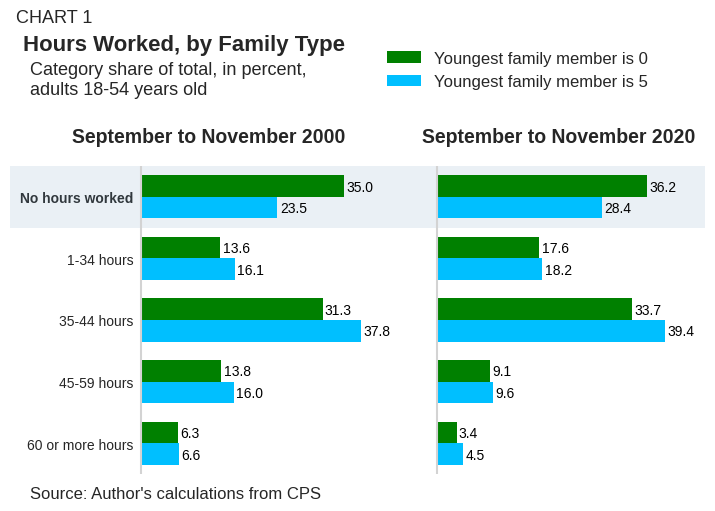

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)

chart1[2000].plot(kind='barh', width=0.7, color=['deepskyblue', 'green'], 
                  figsize=(7, 4), ax=ax1, legend=None, zorder=2)
# add value labels to ends of bars and country names to start of bars
for col in chart1[2000].keys():
    for i, val in enumerate(chart1[2000][col]):
        if col == 'Youngest family member is 5':
            y = i-0.15
        else:
            y = i+0.2
        ax1.text(val+0.4, y-0.1, f'{val:.1f}', color='black')
        
chart1[2020].plot(kind='barh', width=0.7, color=['deepskyblue', 'green'], 
                  figsize=(7, 4), ax=ax2, zorder=2)
# add value labels to ends of bars and country names to start of bars
for col in chart1[2020].keys():
    for i, val in enumerate(chart1[2020][col]):
        if col == 'Youngest family member is 5':
            y = i-0.15
        else:
            y = i+0.2
        ax2.text(val+0.4, y-0.1, f'{val:.1f}', color='black')

fig.text(-0.05, 1.24, 'CHART 1', size=13)
fig.text(-0.04, 1.17, 'Hours Worked, by Family Type', 
          fontsize=16, weight='bold')
fig.text(-0.03, 1.06, 'Category share of total, in percent,\n'+
         'adults 18-54 years old', size=13)
fig.text(-0.03, 0.05, "Source: Author's calculations from CPS", size=12)
fig.text(0.03, 0.94, 'September to November 2000', size=14, weight='bold')
fig.text(0.53, 0.94, 'September to November 2020', size=14, weight='bold')

# Box around no and low hours
ax1.axhspan(3.5, 4.5, xmin=-0.52, xmax = 1.2, fill=True, linewidth=0, 
            color='#74A0C2', alpha=0.15, zorder=1, clip_on=False)
ax2.axhspan(3.5, 4.5, xmin=0, xmax = 1.1, fill=True, linewidth=0, 
            color='#74A0C2', alpha=0.15, zorder=1, clip_on=False)

handles, labels = plt.gca().get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], loc='lower left', bbox_to_anchor=(-0.25, 1.2), fontsize=12)
ax1.get_yticklabels()[-1].set_weight("bold")
ax1.axes.xaxis.set_ticklabels([])
ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])
ax1.set_xlim([-0.5, 42])
ax1.set_ylim([-0.5, 4.5])
ax1.axvline(x=0, color='lightgray')
ax2.set_xlim([-0.5, 42])
ax2.set_ylim([-0.5, 4.5])
ax2.axvline(x=0, color='lightgray');

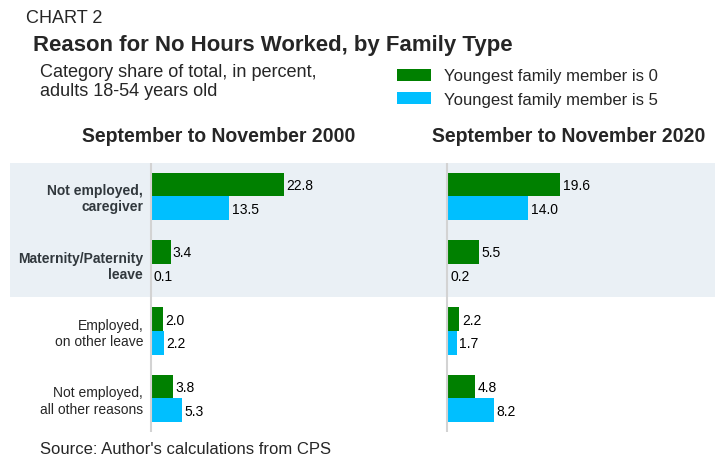

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)

chart2[2000].plot(kind='barh', width=0.7, color=['deepskyblue', 'green'], 
                  figsize=(7, 3.5), ax=ax1, legend=None, zorder=2)
# add value labels to ends of bars and country names to start of bars
for col in chart2[2000].keys():
    for i, val in enumerate(chart2[2000][col]):
        if col == 'Youngest family member is 5':
            y = i-0.15
        else:
            y = i+0.2
        ax1.text(val+0.4, y-0.1, f'{val:.1f}', color='black')
        
chart2[2020].plot(kind='barh', width=0.7, color=['deepskyblue', 'green'], 
                  figsize=(7, 3.5), ax=ax2, zorder=2)
# add value labels to ends of bars and country names to start of bars
for col in chart2[2020].keys():
    for i, val in enumerate(chart2[2020][col]):
        if col == 'Youngest family member is 5':
            y = i-0.15
        else:
            y = i+0.2
        ax2.text(val+0.4, y-0.1, f'{val:.1f}', color='black')

fig.text(-0.05, 1.28, 'CHART 2', size=13)
fig.text(-0.04, 1.2, 'Reason for No Hours Worked, by Family Type', 
          fontsize=16, weight='bold')
fig.text(-0.03, 1.07, 'Category share of total, in percent,\n'+
         'adults 18-54 years old', size=13)
fig.text(-0.03, 0.05, "Source: Author's calculations from CPS", size=12)
fig.text(0.03, 0.94, 'September to November 2000', size=14, weight='bold')
fig.text(0.53, 0.94, 'September to November 2020', size=14, weight='bold')

# Box around no and low hours
ax1.axhspan(1.5, 3.5, xmin=-0.56, xmax = 1.2, fill=True, linewidth=0, 
            color='#74A0C2', alpha=0.15, zorder=1, clip_on=False)
ax2.axhspan(1.5, 3.5, xmin=0, xmax = 1.1, fill=True, linewidth=0, 
            color='#74A0C2', alpha=0.15, zorder=1, clip_on=False)

handles, labels = plt.gca().get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], loc='lower left', bbox_to_anchor=(-0.25, 1.15), fontsize=12)
ax1.get_yticklabels()[-1].set_weight("bold")
ax1.get_yticklabels()[-2].set_weight("bold")
ax1.axes.xaxis.set_ticklabels([])
ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])
ax1.set_xlim([-0.5, 42])
ax1.set_ylim([-0.5, 3.5])
ax1.axvline(x=0, color='lightgray')
ax2.set_xlim([-0.5, 42])
ax2.set_ylim([-0.5, 3.5])
ax2.axvline(x=0, color='lightgray');

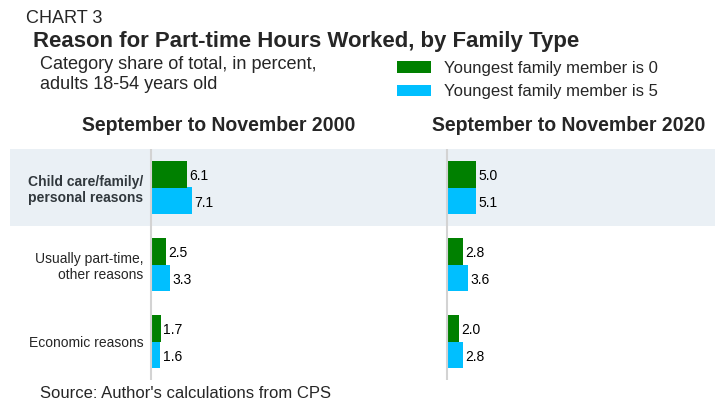

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)

chart3[2000].plot(kind='barh', width=0.7, color=['deepskyblue', 'green'], 
                  figsize=(7, 3), ax=ax1, legend=None, zorder=2)
# add value labels to ends of bars and country names to start of bars
for col in chart3[2000].keys():
    for i, val in enumerate(chart3[2000][col]):
        if col == 'Youngest family member is 5':
            y = i-0.15
        else:
            y = i+0.2
        ax1.text(val+0.4, y-0.1, f'{val:.1f}', color='black')
        
chart3[2020].plot(kind='barh', width=0.7, color=['deepskyblue', 'green'], 
                  figsize=(7, 3), ax=ax2, zorder=2)
# add value labels to ends of bars and country names to start of bars
for col in chart3[2020].keys():
    for i, val in enumerate(chart3[2020][col]):
        if col == 'Youngest family member is 5':
            y = i-0.15
        else:
            y = i+0.2
        ax2.text(val+0.4, y-0.1, f'{val:.1f}', color='black')

fig.text(-0.05, 1.3, 'CHART 3', size=13)
fig.text(-0.04, 1.22, 'Reason for Part-time Hours Worked, by Family Type', 
          fontsize=16, weight='bold')
fig.text(-0.03, 1.08, 'Category share of total, in percent,\n'+
         'adults 18-54 years old', size=13)
fig.text(-0.03, 0.05, "Source: Author's calculations from CPS", size=12)
fig.text(0.03, 0.94, 'September to November 2000', size=14, weight='bold')
fig.text(0.53, 0.94, 'September to November 2020', size=14, weight='bold')

# Box around no and low hours
ax1.axhspan(1.5, 2.5, xmin=-0.56, xmax = 1.2, fill=True, linewidth=0, 
            color='#74A0C2', alpha=0.15, zorder=1, clip_on=False)
ax2.axhspan(1.5, 2.5, xmin=0, xmax = 1.1, fill=True, linewidth=0, 
            color='#74A0C2', alpha=0.15, zorder=1, clip_on=False)

handles, labels = plt.gca().get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], loc='lower left', bbox_to_anchor=(-0.25, 1.15), fontsize=12)
ax1.get_yticklabels()[-1].set_weight("bold")
ax1.axes.xaxis.set_ticklabels([])
ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])
ax1.set_xlim([-0.5, 42])
ax1.set_ylim([-0.5, 2.5])
ax1.axvline(x=0, color='lightgray')
ax2.set_xlim([-0.5, 42])
ax2.set_ylim([-0.5, 2.5])
ax2.axvline(x=0, color='lightgray');

In [7]:
statelist = ['CA', 'NJ', 'RI', 'NY', 'WA', 'DC']
groups = [('No State Law', 'AGE0 > 0 and STATE not in @statelist'),
          ('State Law (As of September 2020)', 'AGE0 > 0 and STATE in @statelist')]

cats = [('Unpaid maternity/\npaternity leave', 
         'ABSTYPE == "Maternity/Paternity" and ABSPAID == "Unpaid"'),
        ('Paid maternity/\npaternity leave', 
         'ABSTYPE == "Maternity/Paternity" and ABSPAID == "Paid"')]


chart4 = {}
for year in [2000, 2020]:
    chart4[year] = pd.DataFrame()
    df = (pd.read_feather(f'cps{year}.ft').query('MONTH in [9, 10, 11]')
            .assign(A0 = a0, AGE0 = age0)
            .drop(['A0'], axis=1)
            .query('18 <= AGE <= 54'))

    for name, query in groups:
        df0 = df.query(query)
        tot = df0.PWSSWGT.sum()
        # Chart 2
        for cname, q in cats:
            data = df0.query(q).PWSSWGT.sum() / tot
            chart4[year].loc[cname, name] = data * 100

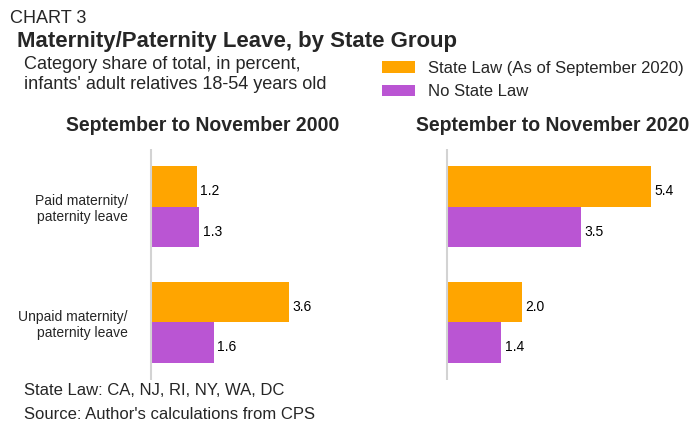

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)

chart4[2000].plot(kind='barh', width=0.7, color=['mediumorchid', 'orange'], 
                  figsize=(7, 2.3), ax=ax1, legend=None, zorder=2)
# add value labels to ends of bars and country names to start of bars
for col in chart4[2000].keys():
    for i, val in enumerate(chart4[2000][col]):
        if col == 'No State Law':
            y = i-0.15
        else:
            y = i+0.2
        ax1.text(val+0.1, y-0.1, f'{val:.1f}', color='black')
        
chart4[2020].plot(kind='barh', width=0.7, color=['mediumorchid', 'orange'], 
                  figsize=(7, 3), ax=ax2, zorder=2)
# add value labels to ends of bars and country names to start of bars
for col in chart4[2020].keys():
    for i, val in enumerate(chart4[2020][col]):
        if col == 'No State Law':
            y = i-0.15
        else:
            y = i+0.2
        ax2.text(val+0.1, y-0.1, f'{val:.1f}', color='black')

fig.text(-0.05, 1.3, 'CHART 3', size=13)
fig.text(-0.04, 1.22, 'Maternity/Paternity Leave, by State Group', 
          fontsize=16, weight='bold')
fig.text(-0.03, 1.08, 'Category share of total, in percent,\n'+
         "infants' adult relatives 18-54 years old", size=13)
fig.text(-0.03, 0.06, "State Law: CA, NJ, RI, NY, WA, DC", size=12)
fig.text(-0.03, -0.02, "Source: Author's calculations from CPS", size=12)
fig.text(0.03, 0.94, 'September to November 2000', size=14, weight='bold')
fig.text(0.53, 0.94, 'September to November 2020', size=14, weight='bold')


handles, labels = plt.gca().get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], loc='lower left', bbox_to_anchor=(-0.25, 1.15), fontsize=12)
ax1.axes.xaxis.set_ticklabels([])
ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])
ax1.set_xlim([-0.5, 6])
ax1.set_ylim([-0.5, 1.5])
ax1.axvline(x=0, color='lightgray')
ax2.set_xlim([-0.5, 6])
ax2.set_ylim([-0.5, 1.5])
ax2.axvline(x=0, color='lightgray');

In [9]:
chart4[2020]

,No State Law,State Law (As of September 2020)
Unpaid maternity/\npaternity leave,1.423343,1.955336
Paid maternity/\npaternity leave,3.516719,5.354254


In [10]:
df0.groupby('ABSPAID').PWSSWGT.sum()

ABSPAID
Paid      198068.890625
Unpaid     71733.398438
Name: PWSSWGT, dtype: float32